In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import train_test_split

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import *
from pubmed_landscape_src.metrics import knn_accuracy_ls

In [4]:
variables_path = Path("../../results/variables/bert-models")
figures_path = Path("../../results/figures/bert-models")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

# Import

In [5]:
# Import
df = pd.read_pickle(berenslab_data_path / "df_labeled_papers_subset")
df = df.reset_index(drop=True)
colors = df["Colors"].to_numpy()

In [6]:
tfidf_features_1M = sp.sparse.load_npz(
    variables_path / "tfidf_features_1M.npz"
)

In [7]:
svd_data_1M = np.load(variables_path / "svd_data_1M.npy")

tcmalloc: large alloc 2400002048 bytes == 0xccfd2000 @ 


In [20]:
#tsne_tfidf_1M = np.load(variables_path / "tsne_tfidf.npy")

# Truncated SVD

In [6]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=1000, random_state=42, algorithm="arpack")
svd_data_1M_n_comp_1k = svd.fit_transform(tfidf_features_1M)

# save results
np.save(variables_path / "svd_data_1M_n_comp_1k", svd_data_1M_n_comp_1k)

tcmalloc: large alloc 12135841792 bytes == 0x54956000 @ 
tcmalloc: large alloc 12135841792 bytes == 0x32b842000 @ 
tcmalloc: large alloc 6064889856 bytes == 0xa2e7a000 @ 
tcmalloc: large alloc 6064889856 bytes == 0x32883a000 @ 
tcmalloc: large alloc 8000004096 bytes == 0x5ffde6000 @ 
tcmalloc: large alloc 6064889856 bytes == 0x492028000 @ 
tcmalloc: large alloc 8000004096 bytes == 0x7dd34c000 @ 
tcmalloc: large alloc 8000004096 bytes == 0x5ffde6000 @ 
tcmalloc: large alloc 6064889856 bytes == 0x492028000 @ 
tcmalloc: large alloc 8000004096 bytes == 0x9ba8b2000 @ 
tcmalloc: large alloc 6064889856 bytes == 0x5ffde6000 @ 
tcmalloc: large alloc 8000004096 bytes == 0x7dd34c000 @ 
tcmalloc: large alloc 8000004096 bytes == 0x7dd34c000 @ 
tcmalloc: large alloc 8000004096 bytes == 0xa2e7a000 @ 


peak memory: 43179.63 MiB, increment: 41511.93 MiB
CPU times: user 19h 37min 36s, sys: 6h 25min 43s, total: 1d 2h 3min 19s
Wall time: 52min 16s


In [7]:
svd_data_1M_n_comp_1k.shape

(1000000, 1000)

# kNN accuracy

In [8]:
def run_tsne(embeddings, rs=42):
    # affinities
    A = affinity.Uniform(
        embeddings,
        k_neighbors=10,
        n_jobs=-1,
        verbose=False,
        random_state=42,
    )

    # initialization
    I = initialization.pca(embeddings, random_state=42)

    # t-SNE optimization
    E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=False)

    ## early exaggeration
    E = E.optimize(
        n_iter=125, exaggeration=12, momentum=0.5, n_jobs=-1, verbose=False
    )

    ## exaggeration annealing
    exs = np.linspace(12, 1, 125)
    for i in range(125):
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=False,
        )

    ## final optimization without exaggeration
    E = E.optimize(
        n_iter=500, exaggeration=1, momentum=0.8, n_jobs=-1, verbose=False
    )

    tsne = np.array(E)

    return tsne

In [ ]:
%%time
Zs = []

for nc in [10, 50, 100, 200, 300, 400, 500]:
    print(".", end="")

    Z1 = run_tsne(svd_data_1M[:, :nc])
    Z2 = run_tsne(normalize(svd_data_1M[:, :nc], axis=1))

    Zs.append((Z1, Z2))

...

tcmalloc: large alloc 1246470144 bytes == 0x1ae630000 @ 


.

tcmalloc: large alloc 1446739968 bytes == 0x2b12f6000 @ 
tcmalloc: large alloc 1600004096 bytes == 0x3076ae000 @ 


In [ ]:
np.save(variables_path / "tsne_SVD_and_L2_SVD_1M", Zs)

In [8]:
Zs = np.load(variables_path / "tsne_SVD_and_L2_SVD_1M.npy")

In [26]:
%%time
print(f"TF-IDF: {knn_accuracy_ls(tfidf_features_1M, colors):.2f}\n")

TF-IDF: 0.61

CPU times: user 47min 46s, sys: 15.3 s, total: 48min 1s
Wall time: 6min 4s


In [ ]:
%%capture cap
%%time
print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate([10, 50, 100, 200, 300]):
    # norms = np.sqrt(np.sum(svd_data_1M[:, :nc] ** 2, axis=1, keepdims=True))
    np.save(variables_path / "iter", i)

    print(
        f"    {nc:3}     {knn_accuracy_ls(svd_data_1M[:,:nc], colors):.3f}"
        f"        {knn_accuracy_ls(normalize(svd_data_1M[:,:nc], axis=1), colors):.3f}"
        f"          {knn_accuracy_ls(Zs[i][0], colors):.3f}"
        f"              {knn_accuracy_ls(Zs[i][1], colors):.3f}"
    )

In [24]:
with open(variables_path / "verbose_knn_accuracy_L2_experiment.txt", "w") as f:
    f.write(cap.stdout)

# Plot

In [8]:
Zs = np.load(variables_path / "tsne_SVD_and_L2_SVD_1M.npy")

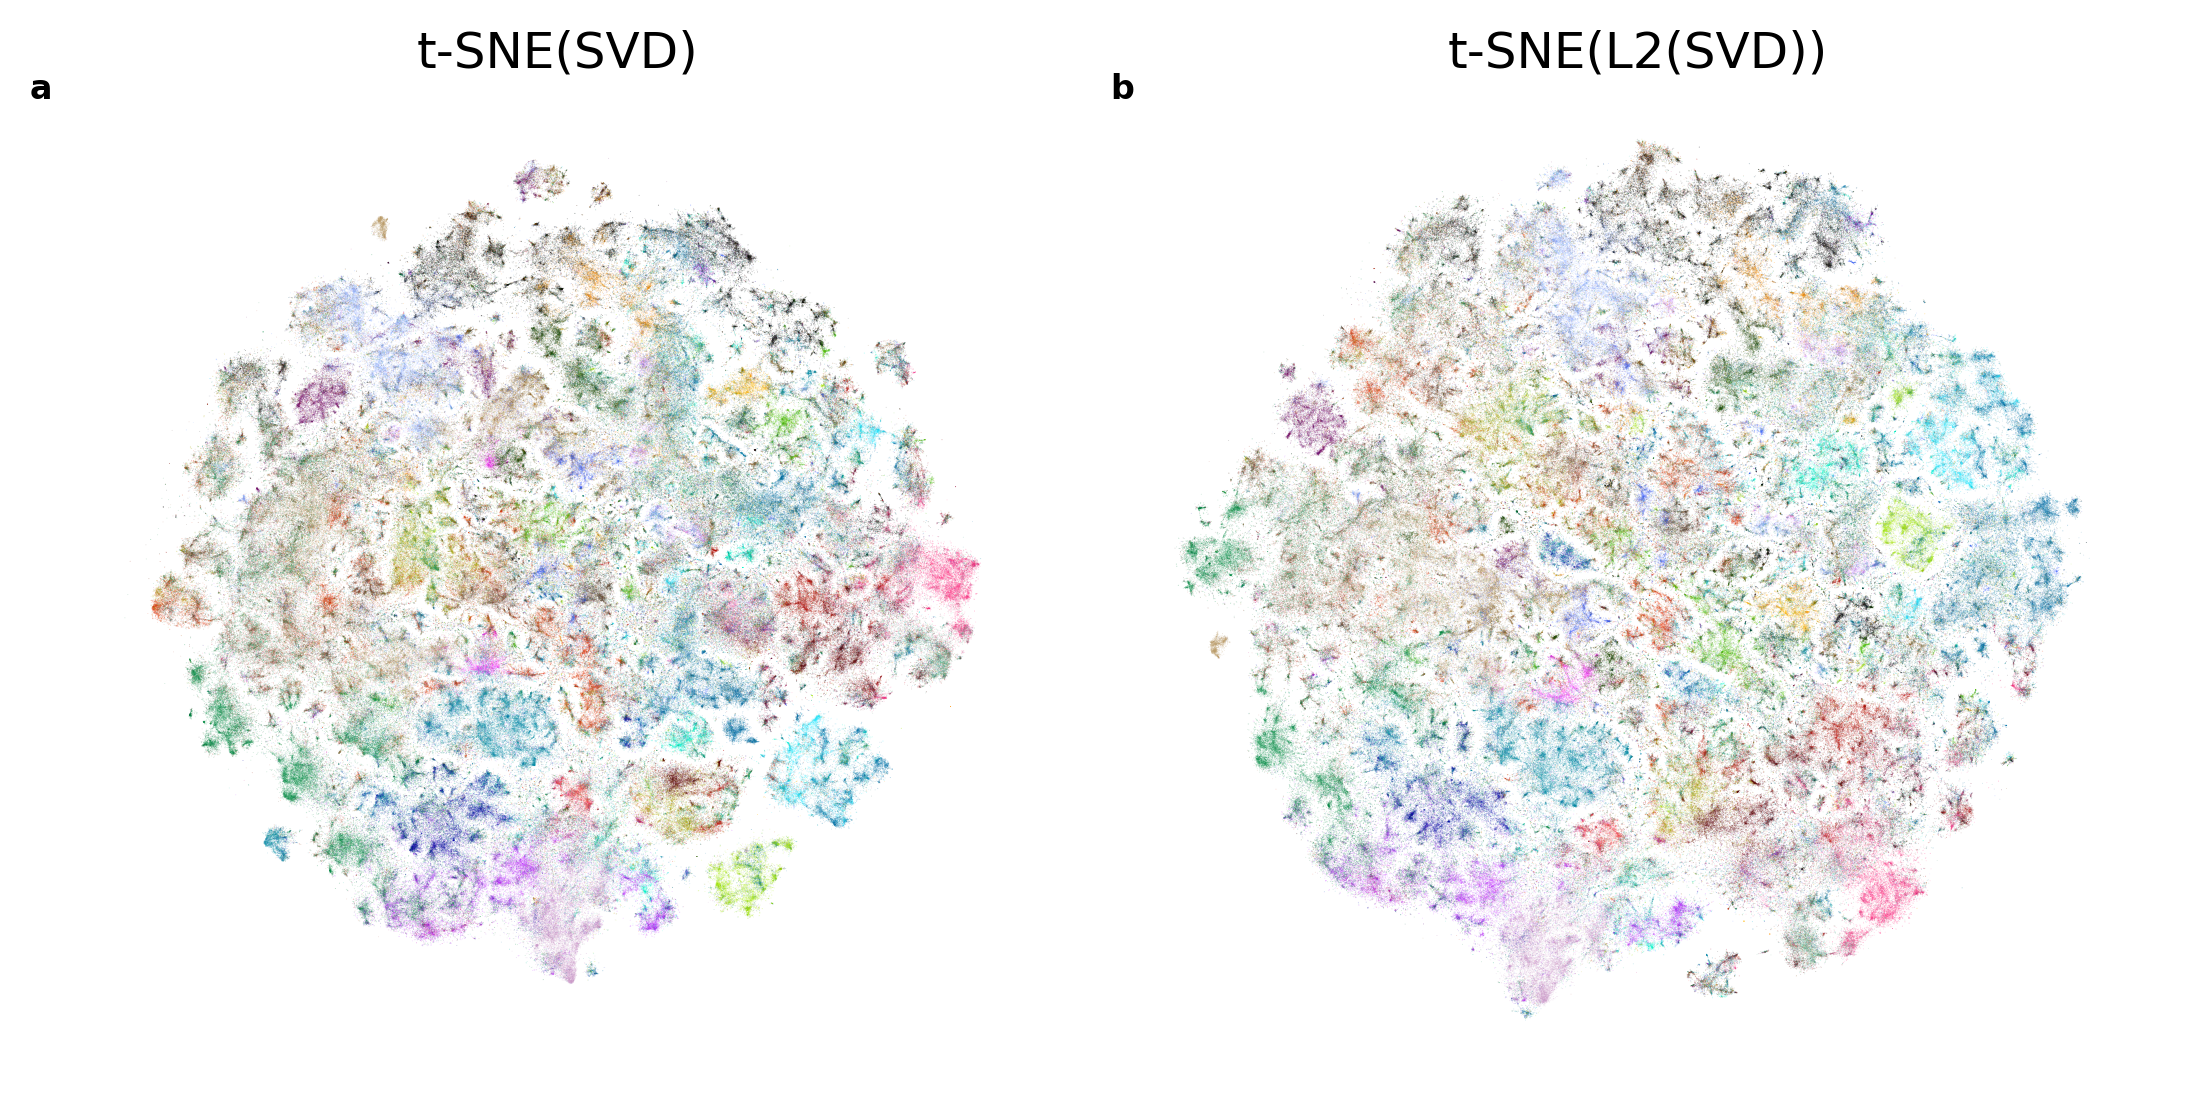

In [38]:
%matplotlib inline
fig, axs = plt.subplots(
    1,
    2,
    figsize=(7.2, 3.6),
    layout="constrained",
    dpi=300,
)

txt_kwargs = dict(size=8, weight="bold", va="top", ha="left")

x_lim = (-110, 110)
y_lim = (-110, 110)

# t-SNE(SVD)
plot_tsne_colors(
    Zs[-1][0],
    colors,
    x_lim=x_lim,
    y_lim=y_lim,
    ax=axs[0],
    plot_type="subplot_2",
)
axs[0].text(
    0,
    1,
    string.ascii_lowercase[0],
    transform=axs[0].transAxes,
    **txt_kwargs,
)
axs[0].set_title("t-SNE(SVD)", y=0.98)
# axs[0].text(
#    0.1,
#    0,
#    f"kNN acc.: {knn_accuracy_tsne_pubmedbert_sep_1M_exgg_1*100:.1f}",
#    transform=axs[0].transAxes,
#    va="bottom",
#    ha="left",
#    size=6,
# )


# t-SNE(L2(SVD))
plot_tsne_colors(
    # Zs[-1][1],
    np.vstack(
        (
            Zs[-1][1][:, 0],
            -Zs[-1][1][:, 1],
        )
    ).T,
    colors,
    x_lim=x_lim,
    y_lim=y_lim,
    ax=axs[1],
    plot_type="subplot_2",
)
axs[1].text(
    0,
    1,
    string.ascii_lowercase[1],
    transform=axs[1].transAxes,
    **txt_kwargs,
)
axs[1].set_title("t-SNE(L2(SVD))", y=0.98)
# axs[1].text(
#    0.1,
#    0,
#    f"kNN acc.: {knn_accuracy_tsne_pubmedbert_sep_1M_exgg_4*100:.1f}",
#    transform=axs[1].transAxes,
#    va="bottom",
#    ha="left",
#    size=6,
# )


fig.savefig(
    figures_path / "tsne_SVD_and_L2_SVD_pubmedbert_sep_1M.png"
)  # _with_knn_acc
fig.savefig(
    figures_path / "tsne_SVD_and_L2_SVD_pubmedbert_sep_1M.pdf"
)  # _with_knn_acc